In [12]:
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
from re import sub
from decimal import Decimal
%matplotlib inline

In [13]:
# Grab WFF table
path = os.getcwd() + '/WFFCreditBounds.csv'  
data = pd.read_csv(path, header=0, index_col='LBW')  
data.head()

,Bound,FTC 1,IWTC 1,FTC 2,IWTC 2,FTC 3,IWTC 3,FTC 4,IWTC 4,FTC 5,IWTC 5,FTC 6,IWTC 6
LBW,,,,,,,,,,,,,
0,0 to 699,92.0,72.0,157.0,72.0,221.0,72.0,286.0,87,350,102,414,117
700,700 to 731,85.0,72.0,150.0,72.0,214.0,72.0,278.0,87,343,102,407,117
732,732 to 760,79.0,72.0,143.0,72.0,207.0,72.0,272.0,87,336,102,401,117
761,761 to 788,72.0,72.0,137.0,72.0,201.0,72.0,265.0,87,330,102,394,117
789,789 to 817,66.0,72.0,130.0,72.0,195.0,72.0,259.0,87,323,102,388,117


In [14]:
# Use functions
def deDollar(str):
    return float(sub(r'[^\d.]', '', str))

# Create People

In [15]:
class Person:
    def __init__(self, hours,hwage,numKids = 0, accom = False,couple = False,livingArea = 1,
                 wHousingCost = 0, renting = True,jobSeeker = False):
        self.hours = hours
        self.hwage = hwage
        self.numKids = numKids
        self.accom = accom
        self.couple = couple
        self.livingArea = livingArea
        self.wHousingCost = wHousingCost
        self.renting = renting
        self.jobSeeker = jobSeeker
    def wibtPre(self):
        return self.hours*self.hwage
    def wibt(self):
        return self.wibtPre() + jobSeeker(self)
    def aibt(self):
        return self.wibt()*52
    def taxOwed(self):
        return taxOwed(self)
    def aiat(self):
        return self.wiat()*52
    def wiat(self):
        return self.wibt()-self.taxOwed()

In [16]:
Person1 = Person(50,18.46,2,True,True, 1, 550, True, False)

# Create Tax Functions

In [17]:
# Set Tax Brackets
tb = [[14000,.105],
      [48000,.175],
      [70000,.3],
      [None,.33]]

def taxBracket1(aIncome):
    return aIncome*tb[0][1]
def taxBracket2(aIncome):
    amountOver = aIncome-tb[0][0]
    return tb[0][0]*tb[0][1] + amountOver*tb[1][1]
def taxBracket3(aIncome):
    amountOver = aIncome-tb[1][0]
    return tb[0][0]*tb[0][1] + (tb[1][0]-tb[0][0])*tb[1][1] + amountOver*tb[2][1]
def taxBracket4(aIncome):
    amountOver = aIncome-tb[2][0]
    return (tb[0][0]*tb[0][1] + 
           (tb[1][0]-tb[0][0])*tb[1][1] + 
           (tb[2][0]-tb[1][0]*tb[2][1] + 
            amountOver*tb[3][1]))

In [18]:
# Get Tax Owed by Annual Income
def taxOwedY(Person):
    aI = Person.aibt()
    if aI <=tb[0][0]:
        return taxBracket1(aI)
    elif aI <= tb[1][0]:
        return taxBracket2(aI)
    elif aI <= tb[2][0]:
        return taxBracket3(aI)
    else:
        return taxBracket4(aI)

def taxOwed(Person):
    return taxOwedY(Person)/52

In [19]:
Person1.taxOwed()

142.67884615384614

# Create Benefit Lookups

In [20]:
def jobSeeker(P):
    if not P.jobSeeker:
        return 0
    sub = 0
    
    if P.wibtPre() < 80:
        wib = 0
    else:
        wib = P.wibtPre() - 80
        
    if P.couple:
        if P.numKids==0:
            sub = 354.06 - (wib)*0.35
        else:
            sub = 379.34 - (wib)*0.35
    else:
        if P.numKids ==0:
            sub = 212.45 - (wib)*0.7
        else:
            if wib < 20:
                sub = 329.57
            elif wib < 120:
                sub = 329.57 - (wib-20)*0.3
            else:
                sub = 329.57 - (0.3 * 100) - (wib-120)*0.7
    if sub<0: sub = 0
    return sub
jobSeeker(Person1)

0

In [21]:
def accom(P):
    if not P.accom:
        return 0
    
    path2 = os.getcwd() + '/AccomBoundsA' + str(P.livingArea) + '.csv'
    data2 = pd.read_csv(path2, header=0)
    
    row = 0
    if P.couple:
        if P.numKids > 0: row = 2 
        else: row = 1
    else:
        if P.numKids == 0: row = 0 
        if P.numKids == 1: row = 3 
        else: row = 4

    cutoff = deDollar(data2.iloc[row,4])
    threshold = deDollar(data2.iloc[row,3])
    maxpay = deDollar(data2.iloc[row,6])
    if P.wibt() > cutoff:
        return 0
    
    path3 = os.getcwd() + '/AccomThreshold.csv'
    data3 = pd.read_csv(path3, header=0)
 
    if P.renting: col = 1
    else: col = 2
    rentthreshold = deDollar(data3.iloc[row,col])
    sub = 0
    if P.wHousingCost > rentthreshold:
        sub = (P.wHousingCost - rentthreshold)*0.7
    if sub>maxpay: sub = maxpay
    if P.wibt()>threshold:
        sub = sub - (P.wibt()-threshold)*0.25

    return sub

# https://www.workandincome.govt.nz/map/income-support/extra-help/accommodation-supplement/income-non-beneficiaries-01.html
accom(Person1)

149.75

In [22]:
# Get Benefits from Table
def ftcEarned(P):
    if P.numKids == 0:
        return 0
    incIndex = data.index.get_loc(P.wibt(), 'pad')
    col = 'FTC ' + str(P.numKids)
    ftc = data.iloc[incIndex, data.columns.get_loc(col)]
    return ftc

def iwtcEarned(P):
    if P.numKids == 0:
        return 0
    if P.hours<20:
        return 0
    incIndex = data.index.get_loc(P.wibt(), 'pad')
    col = 'IWTC ' + str(P.numKids)
    ftc = data.iloc[incIndex, data.columns.get_loc(col)]
    return ftc

def mftcEarned(P):
    if P.numKids == 0:
        return 0
    if P.wiat()<458 and P.hours>=20:
        return 458-P.wiat()
    else:
        return 0
    
def jobseeker(P):
    return

def benefitsReceived(P):
    return (ftcEarned(P) +
            iwtcEarned(P) +
            mftcEarned(P) +
            accom(P) + 
            jobSeeker(P))

In [23]:
accom(Person1)

149.75

# Final Values

In [24]:
def takeHome(P):
    return P.wiat() + benefitsReceived(P) - jobSeeker(P)*0.8
takeHome(Person1)

1106.0711538461537

In [25]:
benefitsReceived(Person1)

325.75

In [26]:
def emtr(P):
    P.hours = P.hours - 1
    temp = takeHome(P)
    P.hours += 1
    diff = (takeHome(P) - temp)
    return 100*(P.hwage-diff)/(P.hwage)
emtr(Person1)

80.419826652222753

# Graph Settings

In [27]:
def initialisePlot(ax):
    # Dumb   
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)     
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()
    return

def setLimits(xmin, xmax, ymin, ymax):
    plt.xlim(xmin, xmax)    
    plt.ylim(ymin, ymax)    
    return

def tickAndDot(mintick,maxtick,tickrange,toLeft="",toRight="",xmin=0,xmax=50):
    # Ticks 
    plt.yticks(range(mintick, maxtick, tickrange), 
               [toLeft + str(i) + toRight for i in range(mintick, maxtick, tickrange)], 
               fontsize=14)
    plt.xticks(fontsize=14)    
    # Lines    
    for i in range(mintick, maxtick, tickrange):    
        plt.plot(range(xmin, xmax), [i] * len(range(xmin, xmax)), "--", lw=0.5, color="black", alpha=0.3)    
    # BS  
    plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")    
    return

def actuallyPlot(ax,x,y1,y2,color1,color2):
    ax.plot(x, y1, lw=2.5, color=color1)
    ax.plot(x, y2, lw=2.5, color=color2) 

def labelAndSave(ax,title, xlab = "",ylab = ""):
    ax.set_ylabel(ylab)   
    ax.set_xlabel(xlab)  
    ax.axhline(linestyle='-', color='k', lw=1);
    plt.title(title, fontsize=17, ha="center");    
    plt.savefig(title + ".png", bbox_inches="tight"); 

# Make Graphs

In [28]:
x = np.linspace(2, 50, 100)
y1 = [0]*100
y2 = [0]*100
j = 0
hold = Person1.hours
hold2 = Person1.jobSeeker
Person1.jobSeeker = False
for i in x:
    Person1.hours = i
    y1[j] = takeHome(Person1)
    j+=1

Person1.jobSeeker = True
j = 0
for i in x:
    Person1.hours = i
    y2[j] = takeHome(Person1)
    j+=1
    
Person1.hours = hold
Person1.jobSeeker = hold2

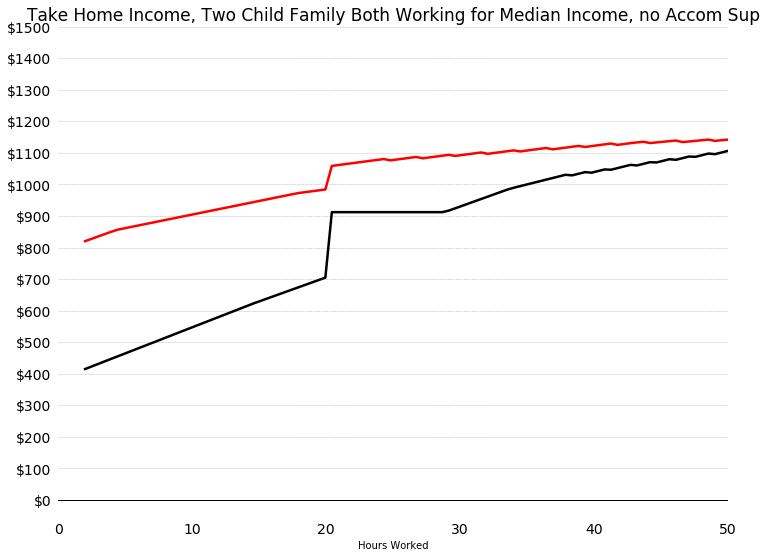

In [29]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)   
initialisePlot(ax)
setLimits(0, 50, -50, 1500)
tickAndDot(0,1501,100,"$","",0,60)
actuallyPlot(ax,x,y1,y2,'k','r')
labelAndSave(ax,'Take Home Income, Two Child Family Both Working for Median Income, no Accom Sup', "Hours Worked")

In [30]:
x = np.linspace(2, 50, 100)
y1 = [0]*100
y2 = [0]*100
j = 0
hold = Person1.hours
hold2 = Person1.jobSeeker
Person1.jobSeeker = False
for i in x:
    Person1.hours = i
    y1[j] = benefitsReceived(Person1)
    j+=1

Person1.jobSeeker = True
j = 0
for i in x:
    Person1.hours = i
    y2[j] = benefitsReceived(Person1)
    j+=1
    
Person1.hours = hold
Person1.jobSeeker = hold2

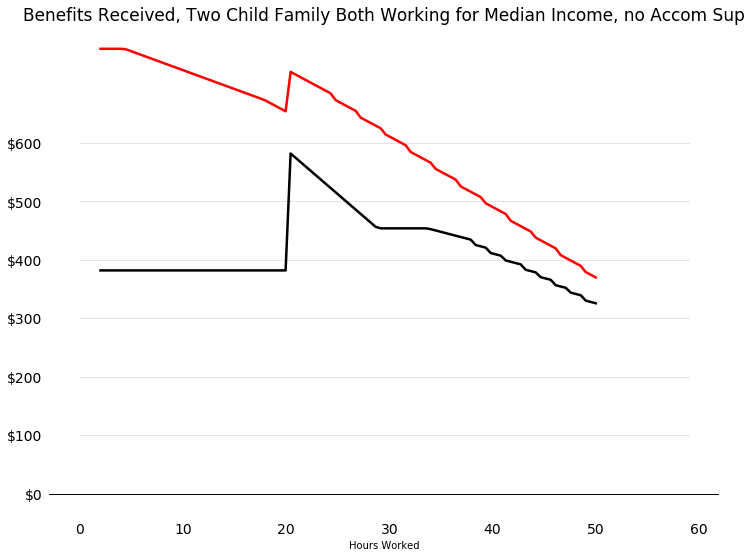

In [31]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)   
initialisePlot(ax)
#setLimits(0, 50, -50, 600)
tickAndDot(0,601,100,"$","",0,60)
actuallyPlot(ax,x,y1,y2,'k','r')
labelAndSave(ax,'Benefits Received, Two Child Family Both Working for Median Income, no Accom Sup', 'Hours Worked')

In [32]:
x = np.linspace(2, 50, 100)
y1 = [0]*100
y2 = [0]*100
j = 0
hold = Person1.hours
hold2 = Person1.jobSeeker
Person1.jobSeeker = False
for i in x:
    Person1.hours = i
    y1[j] = emtr(Person1)
    j+=1

Person1.jobSeeker = True
j = 0
for i in x:
    Person1.hours = i
    y2[j] = emtr(Person1)
    j+=1
    
Person1.hours = hold
Person1.jobSeeker = hold2

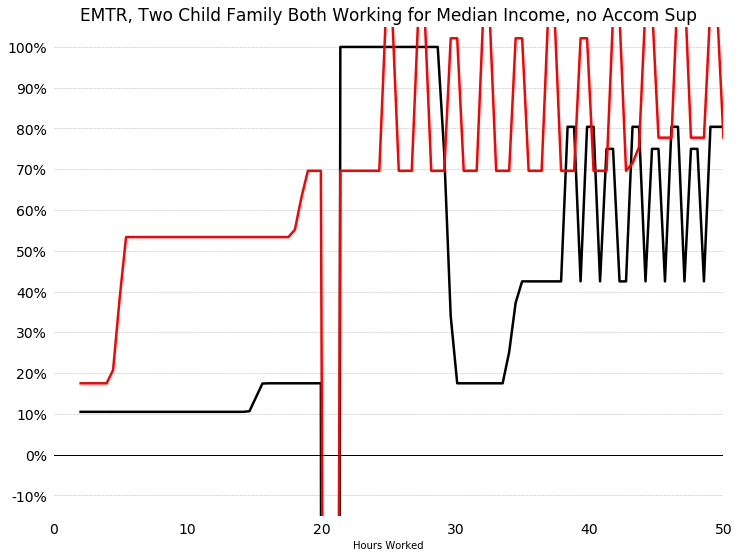

In [33]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)   
initialisePlot(ax)
setLimits(0, 50, -15, 105)
tickAndDot(-10,101,10,"","%",0,60)
actuallyPlot(ax,x,y1,y2,'k','r')
labelAndSave(ax,'EMTR, Two Child Family Both Working for Median Income, no Accom Sup', 'Hours Worked') 

# Function for vital info on a Person

In [34]:
def giveVitals(P):
    print("Hours worked per week: " + str(P.hours))
    print("Hourly wage: " + str(P.hwage))
    print("Weekly income before tax: " + str(P.wibt()))
    print("Annual income before tax: " + str(P.aibt()))
    print("Annual tax owed: " + str(P.taxOwed()))
    print("Benefits received weekly: " + str(benefitsReceived(P)))
    print("Benefits received annually: " + str(benefitsReceived(P)*52))
    print("Take home income weekly: " + str(takeHome(P)))
    print("Take home income annually: " + str(takeHome(P)*52))
    print("Take home income annually less housing: " + str((takeHome(P)-P.wHousingCost)*52))
    print("EMTR: " + str(emtr(P)))
    print("Number of children: " + str(P.numKids))

In [35]:
giveVitals(Person1)

Hours worked per week: 50
Hourly wage: 18.46
Weekly income before tax: 923.0
Annual income before tax: 47996.0
Annual tax owed: 142.67884615384614
Benefits received weekly: 325.75
Benefits received annually: 16939.0
Take home income weekly: 1106.07115385
Take home income annually: 57515.7
Take home income annually less housing: 28915.7
EMTR: 80.4198266522
Number of children: 2


In [36]:
ftcEarned(Person1)

104.0

# Begin looking at macro conditions

<img src="CostsTable.png">
<img src="DetailedCostsTable.png">
<img src="MoreDetailedCostsTable.png">

In [37]:
FamiliesAffected = 380000
TotalCost = 2.4e9
CostPerFamily=TotalCost/FamiliesAffected
print(CostPerFamily)
FTC2016 = 1837e6
Rest2016 = 577e6
FTCPortion = FTC2016/(FTC2016+Rest2016)
print(FTCPortion)

6315.789473684211
0.7609776304888153


In [38]:
WfF = (mftcEarned(Person1)+ftcEarned(Person1)+iwtcEarned(Person1))*52
ftc = ftcEarned(Person1)*52
print(mftcEarned(Person1))
print(WfF)
print(ftc)
print(ftc/WfF)

0
9152.0
5408.0
0.590909090909


## Can see that our family differs from the norm in working above the limit - the difference is likely in non-working families and families on MFTC/PTC/CTC. Former is bigger.

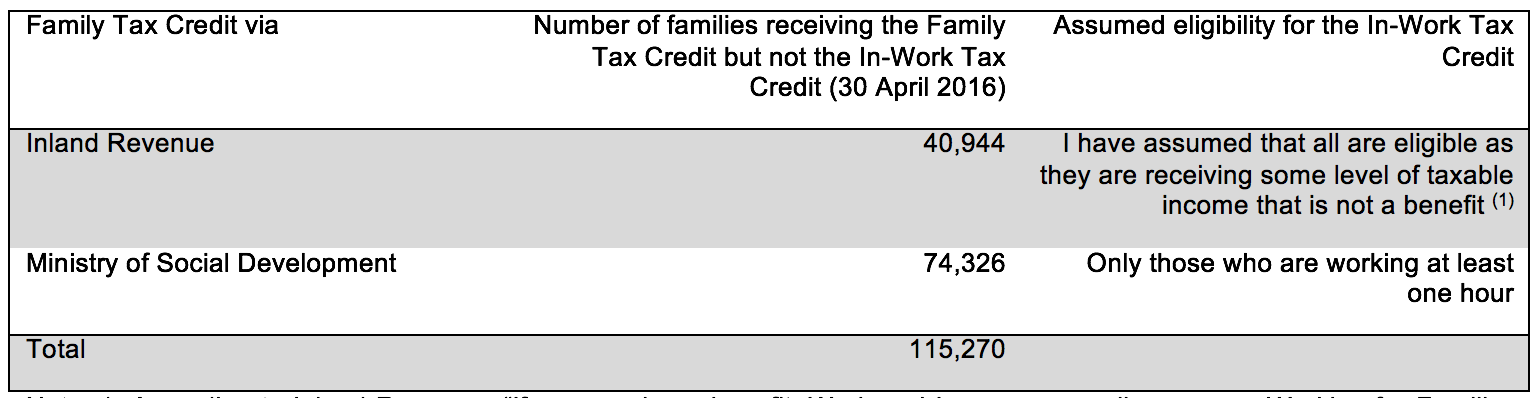

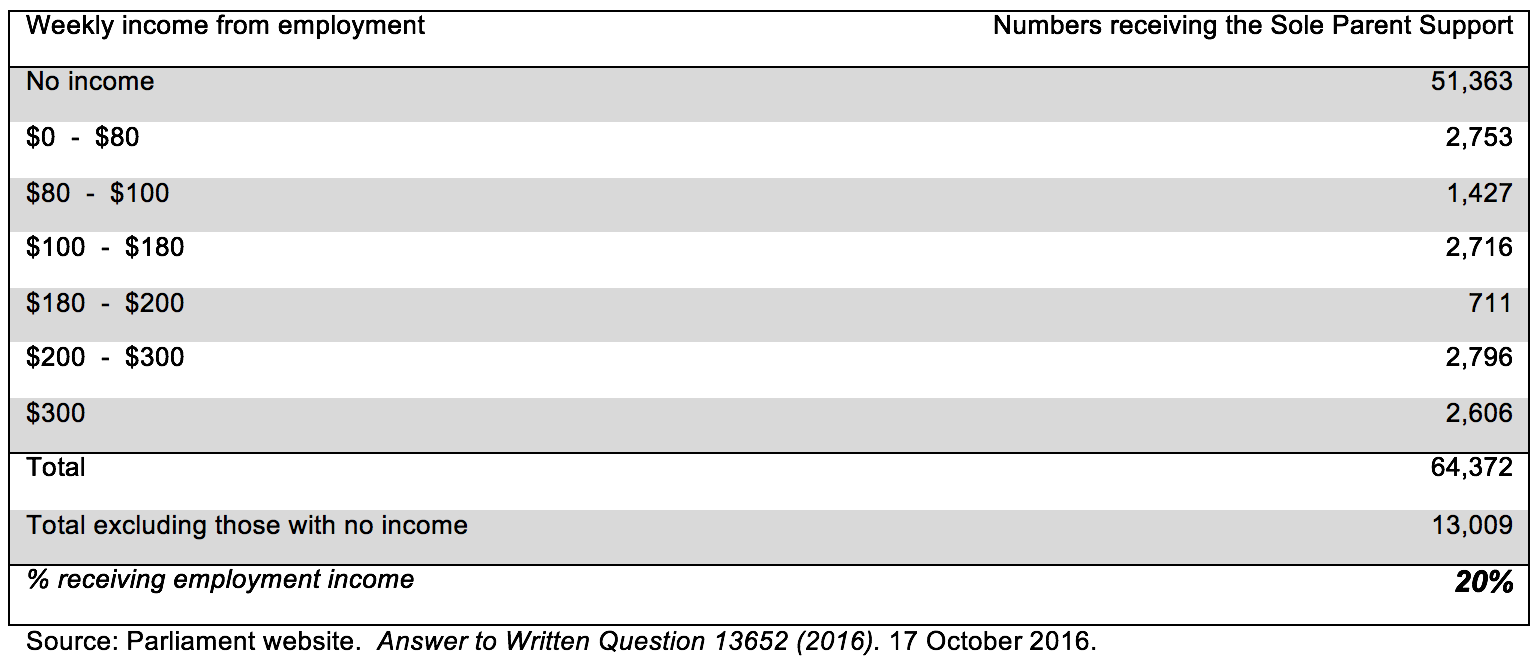

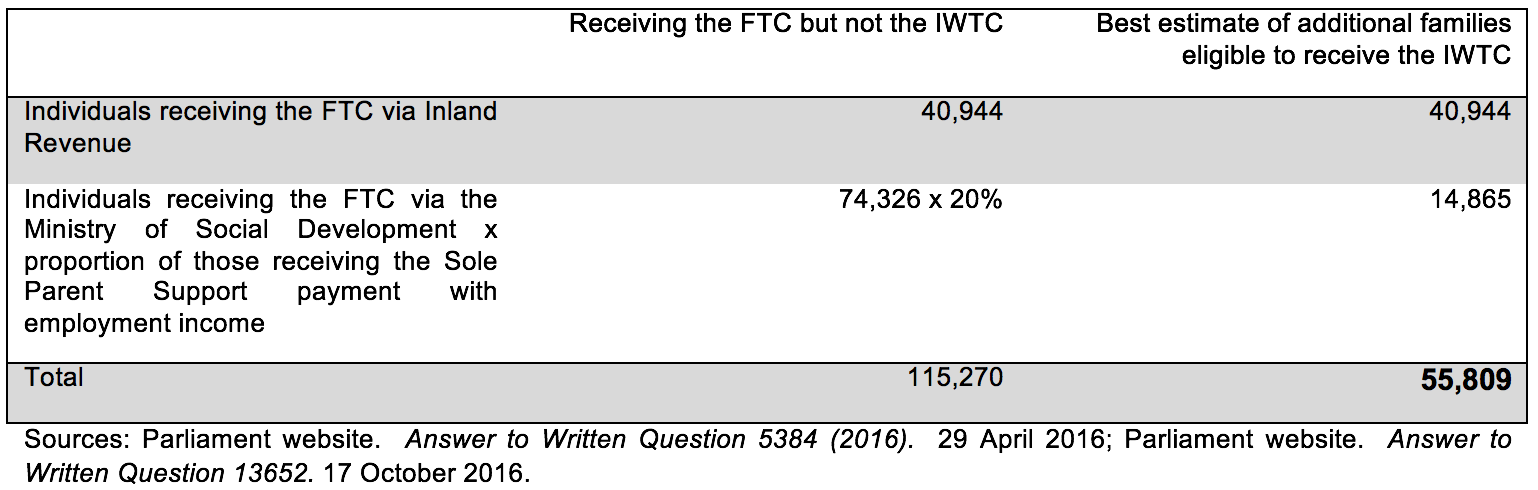


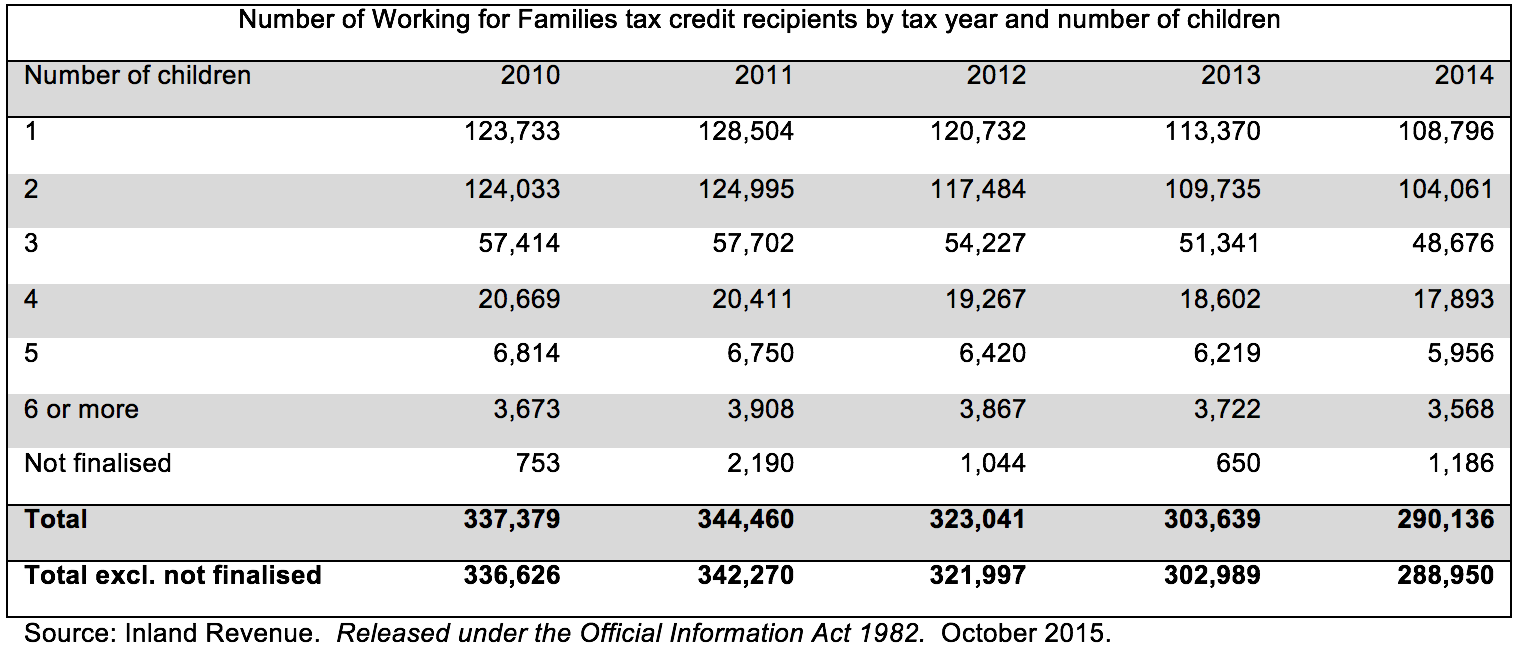

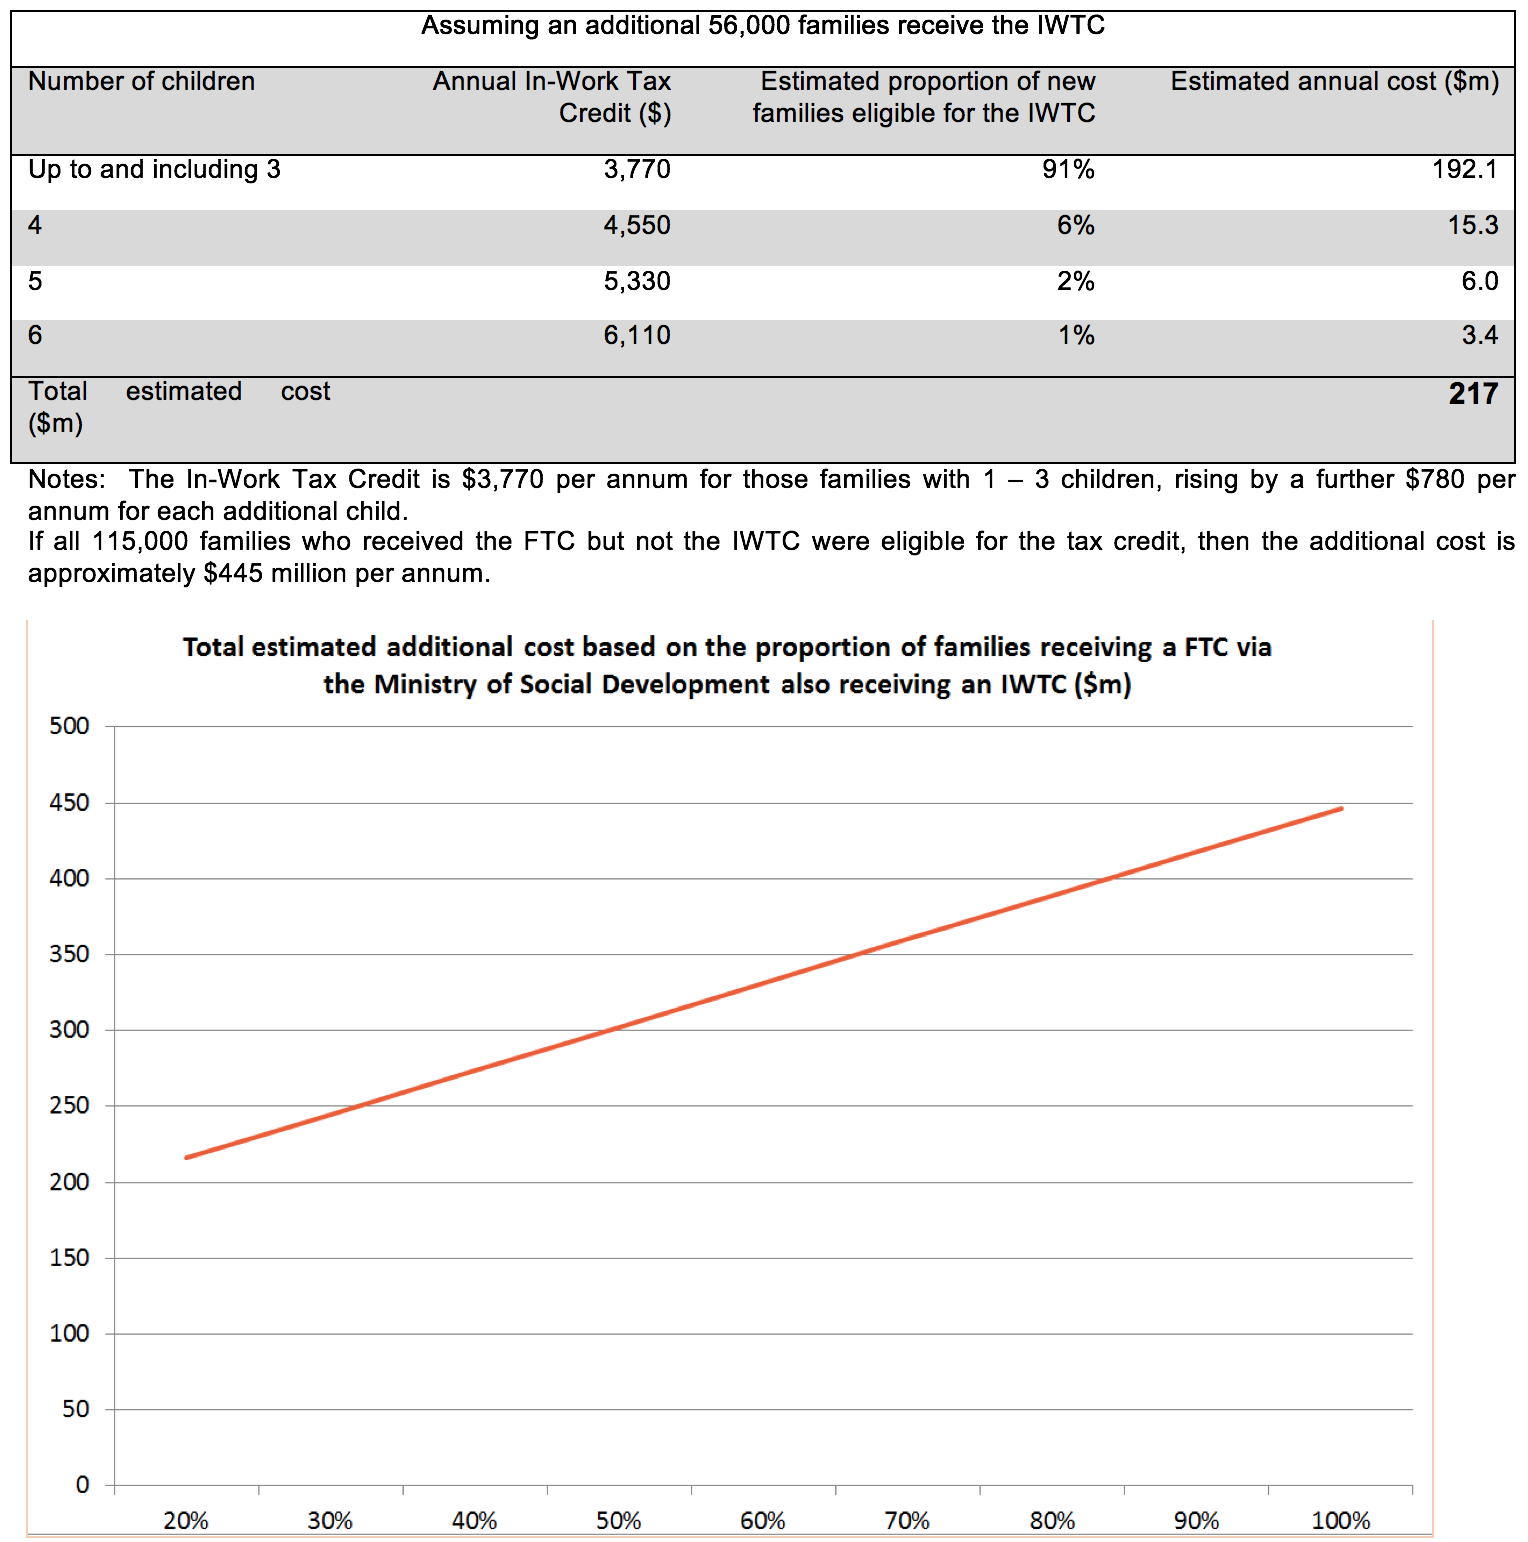

## New Families

Single parent on 30000 with 1 child living in Auckland

35000 with 4 kids 2 parents living in Auckland

Single parent earning 50,000 with 3 children living in Auckland

All on minimum wage

In [39]:
Person2 = Person(30000/(52*15.75),15.75,numKids = 1, accom = True,couple = False,livingArea = 1,
                 wHousingCost = 370, renting = True,jobSeeker = False)

Person3 = Person(35000/(52*15.75),15.75,numKids = 4, accom = True,couple = True,livingArea = 1,
                 wHousingCost = 662, renting = True,jobSeeker = False)

Person4 = Person(50000/(52*15.75),15.75,numKids = 2, accom = True,couple = False,livingArea = 1,
                 wHousingCost = 470, renting = True,jobSeeker = False)

# Costs taken from https://www.tenancy.govt.nz/rent-bond-and-bills/market-rent/?location=howick&period=55&action_doSearchValues=Find+Rent
# In Howick

In [40]:
giveVitals(Person2)

Hours worked per week: 36.63003663003663
Hourly wage: 15.75
Weekly income before tax: 576.9230769230769
Annual income before tax: 30000.0
Annual tax owed: 82.11538461538461
Benefits received weekly: 317.519230769
Benefits received annually: 16511.0
Take home income weekly: 812.326923077
Take home income annually: 42241.0
Take home income annually less housing: 23001.0
EMTR: 42.5
Number of children: 1


In [41]:
giveVitals(Person3)

Hours worked per week: 42.73504273504273
Hourly wage: 15.75
Weekly income before tax: 673.076923076923
Annual income before tax: 34999.99999999999
Annual tax owed: 98.94230769230765
Benefits received weekly: 585.230769231
Benefits received annually: 30432.0
Take home income weekly: 1159.36538462
Take home income annually: 60287.0
Take home income annually less housing: 25863.0
EMTR: 42.5
Number of children: 4


In [42]:
giveVitals(Person4)

Hours worked per week: 61.05006105006105
Hourly wage: 15.75
Weekly income before tax: 961.5384615384615
Annual income before tax: 50000.0
Annual tax owed: 154.23076923076923
Benefits received weekly: 292.365384615
Benefits received annually: 15203.0
Take home income weekly: 1099.67307692
Take home income annually: 57183.0
Take home income annually less housing: 32743.0
EMTR: 55.0
Number of children: 2


## If they all currently are above IWTC threshold, scale back income and see under

In [43]:
Person2.hours = 19
#Person2.jobSeeker = True
giveVitals(Person2)

Hours worked per week: 19
Hourly wage: 15.75
Weekly income before tax: 299.25
Annual income before tax: 15561.0
Annual tax owed: 33.52259615384615
Benefits received weekly: 252.0
Benefits received annually: 13104.0
Take home income weekly: 517.727403846
Take home income annually: 26921.825
Take home income annually less housing: 7681.825
EMTR: 17.5
Number of children: 1


In [44]:
Person2.hours = 20
#Person2.jobSeeker = True
giveVitals(Person2)

Hours worked per week: 20
Hourly wage: 15.75
Weekly income before tax: 315.0
Annual income before tax: 16380.0
Annual tax owed: 36.27884615384615
Benefits received weekly: 503.278846154
Benefits received annually: 26170.5
Take home income weekly: 782.0
Take home income annually: 40664.0
Take home income annually less housing: 21424.0
EMTR: -1577.92124542
Number of children: 1


In [45]:
Person4.hours = 19
giveVitals(Person4)

Hours worked per week: 19
Hourly wage: 15.75
Weekly income before tax: 299.25
Annual income before tax: 15561.0
Annual tax owed: 33.52259615384615
Benefits received weekly: 382.0
Benefits received annually: 19864.0
Take home income weekly: 647.727403846
Take home income annually: 33681.825
Take home income annually less housing: 9241.825
EMTR: 17.5
Number of children: 2


In [46]:
Person4.hours = 20
#Person4.jobSeeker = True
giveVitals(Person4)

Hours worked per week: 20
Hourly wage: 15.75
Weekly income before tax: 315.0
Annual income before tax: 16380.0
Annual tax owed: 36.27884615384615
Benefits received weekly: 633.278846154
Benefits received annually: 32930.5
Take home income weekly: 912.0
Take home income annually: 47424.0
Take home income annually less housing: 22984.0
EMTR: -1577.92124542
Number of children: 2


## Tipping point where 1 hour a week minimum wage gets IWTC, and that eats away other benefits

In [47]:
x = np.linspace(2, 50, 100)
y1 = [0]*100
y2 = [0]*100
j = 0
hold = Person2.hours
hold2 = Person2.jobSeeker
Person2.jobSeeker = False
for i in x:
    Person2.hours = i
    y1[j] = benefitsReceived(Person2)
    j+=1

#Person2.jobSeeker = True
#j = 0
#for i in x:
#    Person2.hours = i
#    y2[j] = benefitsReceived(Person2)
#    j+=1
    
Person2.hours = hold
Person2.jobSeeker = hold2

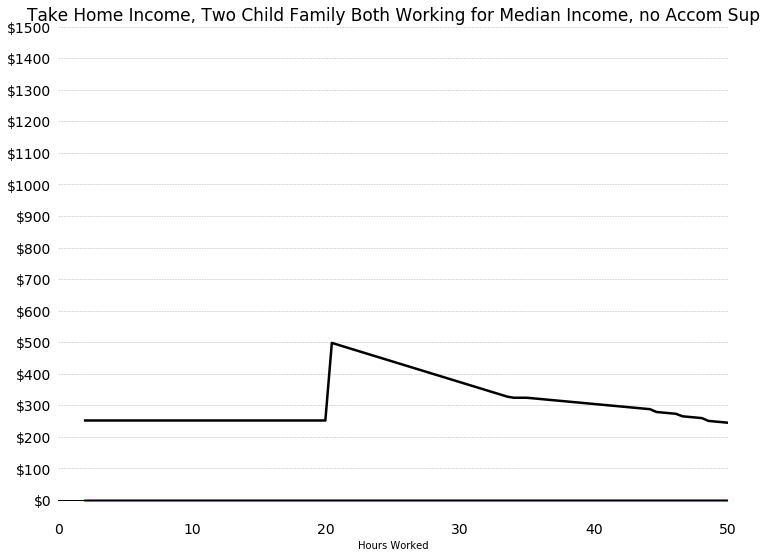

In [48]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)   
initialisePlot(ax)
setLimits(0, 50, -50, 1500)
tickAndDot(0,1501,100,"$","",0,60)
actuallyPlot(ax,x,y1,y2,'k','r')
labelAndSave(ax,'Take Home Income, Two Child Family Both Working for Median Income, no Accom Sup', "Hours Worked")

In [49]:
x = np.linspace(2, 50, 100)
y1 = [0]*100
y2 = [0]*100
j = 0
hold = Person3.hours
hold2 = Person3.jobSeeker
Person3.jobSeeker = False
for i in x:
    Person3.hours = i
    y1[j] = benefitsReceived(Person3)
    j+=1

#Person3.jobSeeker = True
#j = 0
#for i in x:
#    Person3.hours = i
#    y2[j] = benefitsReceived(Person3)
#    j+=1
    
Person3.hours = hold
Person3.jobSeeker = hold2

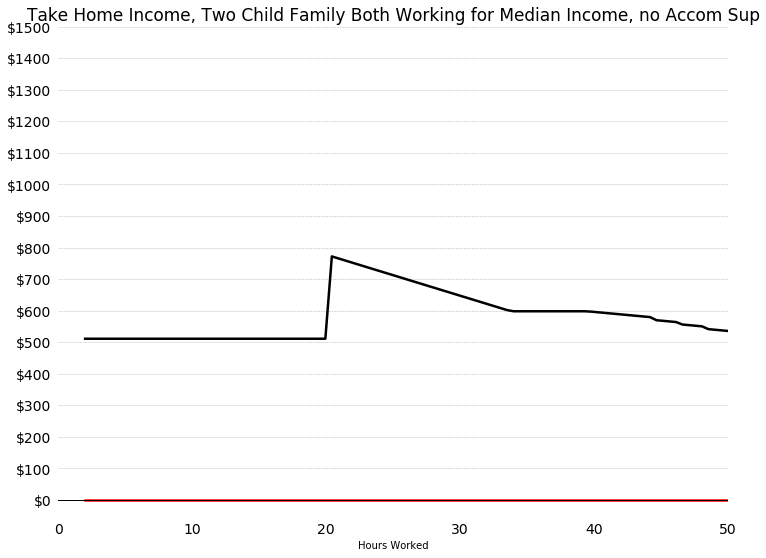

In [50]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)   
initialisePlot(ax)
setLimits(0, 50, -50, 1500)
tickAndDot(0,1501,100,"$","",0,60)
actuallyPlot(ax,x,y1,y2,'k','r')
labelAndSave(ax,'Take Home Income, Two Child Family Both Working for Median Income, no Accom Sup', "Hours Worked")